# L9 多分类编程

## 第一题
### 1.1 用ovo方法实现对鸢尾花数据集的分类

**相关库的导入**:首先，我们导入编写代码需要用到的库。其中，numpy库主要用于对多维数组进行数值计算和科学计算，matplotlib库主要用于绘制图形，sklearb库中导入的datasets模块主要用于获取数据集(也可以直接用文件中给出的数据集)，sklearn.linear_model中导入的Perceptron主要用于实现简单的感知器算法，sklearn.metrics 中的 accuracy_score 函数用于计算分类模型的准确率。它可以用于评估模型在测试数据集上的性能。

In [494]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

**实验数据的生成和划分**:
- 首先加载鸢尾花数据集，这里为了方便起见，直接利用sklearn.datasets中的load_iris函数加载鸢尾花数据集。

In [495]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

- 然后进行实验数据的划分，根据题目要求，应当随机将每个类别中选30个样本进行训练，其余的样本进行测试。为实现随机性，可以导入random库实现随机数的生成。这里，我们将数据集中的样本进行随机打乱，得到打乱之后的样本X_shuffled与其对应的标签y_shuffled。然后利用np.unique和np.where分别找出标签为0，1，2的样本的索引，分别选取其中的前30个样本作为训练样本，其余的样本作为测试样本。

In [496]:
n_samples = len(y)
random_indices = random.sample(range(n_samples), n_samples)
X_shuffled = X[random_indices]
y_shuffled = y[random_indices]
train_indices = []
test_indices = []
for class_label in np.unique(y_shuffled):
    indices = np.where(y_shuffled == class_label)[0]
    train_indices.extend(indices[:30])
    test_indices.extend(indices[30:50])
X_train = X_shuffled[train_indices]
y_train = y_shuffled[train_indices]
X_test = X_shuffled[test_indices]
y_test = y_shuffled[test_indices]


**感知器算法的实现**:
- 参考此前L2中已经写过的感知器算法，可写出如下代码，实现每两个类别的分类。设置学习率为1，最大迭代次数为1000.

In [497]:
def perceptron_train(X, y, max_iterations=1000):
    num_samples, num_features = X.shape
    w = np.zeros(num_features)  
    for _ in range(max_iterations):
        error = 0
        for i in range(num_samples):
            if y[i] * np.dot(X[i], w) <= 0:
                w +=  y[i] * X[i]
                error += 1
        if error == 0:
            break
    return w

**ovo分类器的训练**:   
- 由于题目要求实现ovo分类器，因此需要对每两个类别进行训练，得到三个分类器。这里我们利用上面写好的分类器对每两类之间进行分类。首先用np.unique可以找出标签中的类别数，这里为3类。创建一个空列表ovo_classifiers，用于存放每两类之间的分类器。随后进行两层迭代，外层迭代从第0类开始，内层迭代从外层迭代的下一类开始，这样就可以得到每两类之间的分类器。在内层迭代中，假设我们想要分类的两类标签为i和j，那么我们就可以利用np.where找出标签为i和j的样本的索引。np.where指定的参数中，第一个参数为选择样本的条件，第二个参数是一个列表[x,y]，其中x,y表示之前选择的条件分别为true和false时对应要分配的值。这样我们就可以实现对原本样本标签0，1，2向标签-1，1的转换，且比较方便，避免了挨个转换的冗余。转化完成后，代入上面写好的感知器算法，得到每两类之间的分类器。将其存入ovo_classifiers列表中并标记好是哪两类之间的分类器。最后返回ovo_classifiers列表。

In [498]:
def train_ovo_classifiers(X_train, y_train):
    num_classes = len(np.unique(y_train))
    ovo_classifiers = []

    for i in range(num_classes):
        for j in range(i + 1, num_classes):
            class_mask = (y_train == i) | (y_train == j)
            binary_y_train = np.where(y_train[class_mask] == i, 1, -1)
            binary_X_train = X_train[class_mask]
            w = perceptron_train(binary_X_train, binary_y_train)
            ovo_classifiers.append((i, j, w))

    print(ovo_classifiers)
    return ovo_classifiers


**ovo分类器的预测**:
- 首先获取测试集的样本数量、特征数量、ovo分类器的数量。创建一个空数组predictions，用于存放预测结果。随后进行循环，循环时用enumerate函数可以同时获取索引和元素,方便之后查找。再使用np.where，此次判断条件为每个分类器的预测结果是否为1，并分配给原始的标签将其对应的索引，同时将结果存入predictions中。循环结束之后，比较投票结果，得到最终的分类情况。其中np.bincount可以统计非负整数数组中每个整数值出现的次数，也就是得到每一个样本的属于每个标签的被投票次数，再用np.argmax,它可以找出数组中的最大值，也就是最优投票结果，最后返回预测结果。

In [499]:
def ovo_predict(X_test, ovo_classifiers):
    num_samples, _ = X_test.shape
    num_classifiers = len(ovo_classifiers)
    predictions = np.zeros((num_samples, num_classifiers))

    for i, (class1, class2, w) in enumerate(ovo_classifiers):
        binary_prediction = np.where(np.dot(X_test, w) >= 0, class1, class2)
        predictions[:, i] = binary_prediction

    final_predictions = np.array([np.argmax(np.bincount(predictions[i].astype(int))) for i in range(num_samples)])


    return final_predictions


**执行函数，得到结果**:
- 代入训练集、测试集，并得到准确率。

In [500]:
ovo_classifiers = train_ovo_classifiers(X_train, y_train)
y_pred = ovo_predict(X_test, ovo_classifiers)
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")


[(0, 1, array([ 0.2,  3.5, -6.7, -2.2])), (0, 2, array([ 3.2,  5.7, -9.3, -4.4])), (1, 2, array([  89.9,  142.1, -149.8, -167.7]))]
Accuracy: 91.67%


### 1.2 用softmax方法实现对鸢尾花数据集的分类

**相关库的导入**:首先，我们导入编写代码需要用到的库。其中，numpy库主要用于对多维数组进行数值计算和科学计算，matplotlib库主要用于绘制图形，sklearn库中导入的datasets模块主要用于获取数据集(也可以直接用文件中给出的数据集)

In [501]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn import datasets


**实验数据的生成和划分**:
- 首先加载鸢尾花数据集，这里为了方便起见，直接利用sklearn.datasets中的load_iris函数加载鸢尾花数据集。

In [502]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

- 然后进行实验数据的划分，根据题目要求，应当随机将每个类别中选30个样本进行训练，其余的样本进行测试。为实现随机性，可以导入random库实现随机数的生成。这里，我们将数据集中的样本进行随机打乱，得到打乱之后的样本X_shuffled与其对应的标签y_shuffled。然后利用np.unique和np.where分别找出标签为0，1，2的样本的索引，分别选取其中的前30个样本作为训练样本，其余的样本作为测试样本。

In [503]:
n_samples = len(y)
random_indices = random.sample(range(n_samples), n_samples)
X_shuffled = X[random_indices]
y_shuffled = y[random_indices]
train_indices = []
test_indices = []
for class_label in np.unique(y_shuffled):
    indices = np.where(y_shuffled == class_label)[0]
    train_indices.extend(indices[:30])
    test_indices.extend(indices[30:50])
X_train = X_shuffled[train_indices]
y_train = y_shuffled[train_indices]
X_test = X_shuffled[test_indices]
y_test = y_shuffled[test_indices]


- **编写softmax分类代码**
规定学习率为0.01，迭代次数为1000次，样本标签类别共三类。根据理论知识，Softmax回归(Softmax regression)，也称为多项(Multinomial)或多类(Multi-Class)的Logistic回归，是Logistic回归在多分类问题上的推广。首先我们需要知道Softmax函数。Softmax用于多分类过程中，它将多个神经元的输出映射到（0,1）区间内，可以看成概率来理解，其转换式为：$$\sigma(z)_j = \frac{e^{z_j}}{\sum_{k=1}^{K}e^{z_k}}$$
容易得到，$$ argmax {o_i} = argmax {\hat y_i} $$ 
因此softmax运算不改变预测类别输出。对于Softmax的梯度估计，我们有:
![Softmax梯度估计](https://raw.githubusercontent.com/spicycurryz/My_img/main/img/Softmax%E6%A2%AF%E5%BA%A6%E4%BC%B0%E8%AE%A1.png)</br>
其中，</br>
![softmax2](https://raw.githubusercontent.com/spicycurryz/My_img/main/img/softmax2.png)</br>
因此可以编写如下代码完成迭代。

In [504]:
class Softmax_Classifier:
    def __init__(self,num_classfications, learning_rate=0.01, max_iterations=1000):
        self.num_classfications = num_classfications
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations

    def fit(self,X,y):
        num_samples, num_features = X.shape
        num_classes = len(np.unique(y))
        self.weights = np.random.rand(num_features, num_classes)
        self.bias = np.zeros(num_classes)

        for epoch in range(self.max_iterations):
            scores = np.dot(X, self.weights)+self.bias
            exp_scores = np.exp(scores)
            probabilities = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

            log_probabilities = -np.log(probabilities[range(num_samples), y])
            loss = np.mean(log_probabilities)

            dis_scores = probabilities
            dis_scores[range(num_samples), y] -= 1
            dis_scores /= num_samples

            dW = np.dot(X.T, dis_scores)
            db = np.sum(dis_scores, axis=0)
            self.weights += -self.learning_rate * dW
            self.bias += -self.learning_rate * db

            if epoch % 100 == 0:
                print(f"Loss after iteration {epoch}: {loss}")

    def predict(self,X):
        scores = np.dot(X, self.weights) + self.bias
        predictions = np.argmax(scores, axis=1)
        return predictions
    




**实现对鸢尾花数据集的分类**:
- 代入训练集和测试集，并计算得出准确率。

In [505]:
num_classifications=len(np.unique(y_train))
classifier = Softmax_Classifier(num_classfications=num_classifications)
classifier.fit(X_train, y_train)

predictions = classifier.predict(X_test)
accuracy = np.mean(predictions == y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")


Loss after iteration 0: 2.2092583509981503
Loss after iteration 100: 0.681827398069272
Loss after iteration 200: 0.5665775920117981
Loss after iteration 300: 0.510077519212099
Loss after iteration 400: 0.47424273742370776
Loss after iteration 500: 0.4479945409683198
Loss after iteration 600: 0.4270772712022565
Loss after iteration 700: 0.40952085519509096
Loss after iteration 800: 0.39428554473322064
Loss after iteration 900: 0.38076620783243087
Accuracy: 100.00%


## 第二题 利用Softmax回归实现手写数字识别
**原题复现**：给定MNIST数据集，该数据集每个样本为28*28大小的灰度图像，有0到9共10个类别的手写体数字，其中训练样本60000，测试样本10000，编写Softmax算法对该数据集实现分类，权向量初始值由均值为0、标准差为0.01的正态分布产生的随机数得到，统计此时测试集的分类精度（正确分类的样本数/总样本数）。训练时的batch size为256，一共训练10遍epoch，画出训练时的损失函数、训练集上的分类精度和测试集上的分类精度随epoch增加的变化曲线。训练完成后，在测试集上随机抽取10个样本，观察分类结果。 




**导入相关库**：
- 首先，我们导入编写代码需要用到的库。其中，numpy库主要用于对多维数组进行数值计算和科学计算，matplotlib库主要用于绘制图形，sklearn库中导入的datasets模块主要用于获取数据集(也可以直接用文件中给出的数据集)，from sklearn.model_selection import train_test_split用于划分训练集和测试集，from sklearn.metrics import accuracy_score用于计算分类模型的准确率。它可以用于评估模型在测试数据集上的性能。from sklearn.preprocessing import StandardScaler主要用于数据预处理，将数据转化为均值为0，方差为1的标准正态分布。

In [506]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


**数据准备**：
- 考虑到方便起见，直接从sklearn.datasets中导入MNIST数据集。（也可以从本地文件导入）然后，利用train_test_split函数将数据集划分为训练集和测试集，其中测试集占比为0.2。随后，利用StandardScaler函数对数据进行预处理，将数据转化为均值为0，方差为1的标准正态分布。同时为样本添加偏置项，进行增广化。

In [507]:
# 加载MNIST数据集
mnist = fetch_openml("mnist_784")
X, y = mnist.data, mnist.target.astype(int)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 特征标准化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 添加偏置项
X_train = np.insert(X_train, 0, 1, axis=1)
X_test = np.insert(X_test, 0, 1, axis=1)

C:\Users\spicycurryz\AppData\Roaming\Python\Python39\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


**编写softmax分类代码**：
- 首先定义softmax函数，然后再初始化权重，给定训练参数learning_rate = 0.1，num_epochs = 10，batch_size = 256。分块训练得到并绘出梯度下降曲线。同时在测试集上进行分类，计算分类精度。

Epoch 1/10, Loss: 0.3100
Epoch 2/10, Loss: 0.2842
Epoch 3/10, Loss: 0.2726
Epoch 4/10, Loss: 0.2654
Epoch 5/10, Loss: 0.2597
Epoch 6/10, Loss: 0.2560
Epoch 7/10, Loss: 0.2523
Epoch 8/10, Loss: 0.2497
Epoch 9/10, Loss: 0.2472
Epoch 10/10, Loss: 0.2452
Test Accuracy: 92.06%


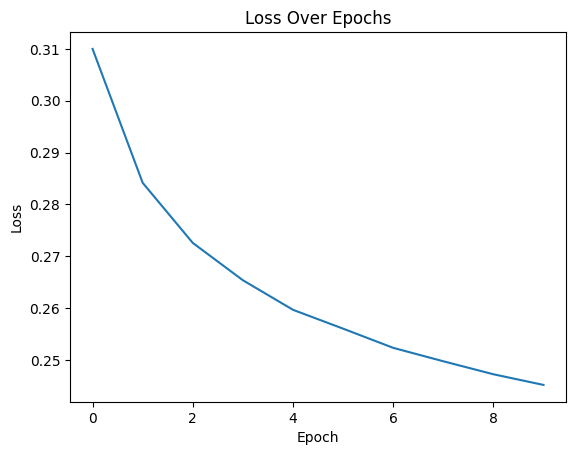

In [508]:
# 定义Softmax回归函数
def softmax(X):
    exp_X = np.exp(X - np.max(X, axis=1, keepdims=True))
    return exp_X / exp_X.sum(axis=1, keepdims=True)

# 初始化权重
num_classes = len(np.unique(y_train))
num_features = X_train.shape[1]
W = np.random.normal(0, 0.01, (num_features, num_classes))

# 训练Softmax回归
learning_rate = 0.1
num_epochs = 10
batch_size = 256
losses = []

for epoch in range(num_epochs):
    for i in range(0, X_train.shape[0], batch_size):
        X_batch = X_train[i:i + batch_size]
        y_batch = y_train[i:i + batch_size]

        scores = np.dot(X_batch, W)
        probabilities = softmax(scores)
        num_samples = X_batch.shape[0]

        dscores = probabilities
        dscores[range(num_samples), y_batch] -= 1
        dscores /= num_samples

        dW = np.dot(X_batch.T, dscores)
        W -= learning_rate * dW

    scores = np.dot(X_train, W)
    probabilities = softmax(scores)
    loss = -np.log(probabilities[range(X_train.shape[0]), y_train]).mean()
    losses.append(loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss:.4f}")

# 预测测试集
test_scores = np.dot(X_test, W)
test_probabilities = softmax(test_scores)
y_pred = np.argmax(test_probabilities, axis=1)

# 计算分类精度
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# 绘制损失函数曲线
plt.plot(losses)
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


**随机抽取10个测试集样本，观察分类结果**：
- 对于上面训练完的结果，我们应用于测试集之后还没有对其进行可视化，不便于展示效果。因此，我们随机抽取10个测试集样本，观察分类结果。首先，我们利用random库随机生成10个索引，且保证大小不超过测试集样本数量。然后，利用matplotlib库中的pyplot模块，将10个样本的图片和其对应的标签打印出来，观察分类结果，并且同时将真实标签和预测标签显示在图片上，使得结果更加直观。

[13342, 12771, 4269, 9937, 6909, 2992, 6510, 3103, 13378, 13198]


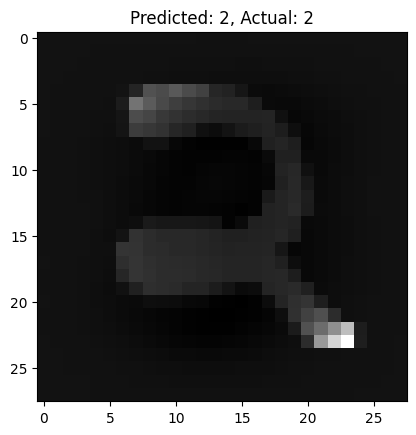

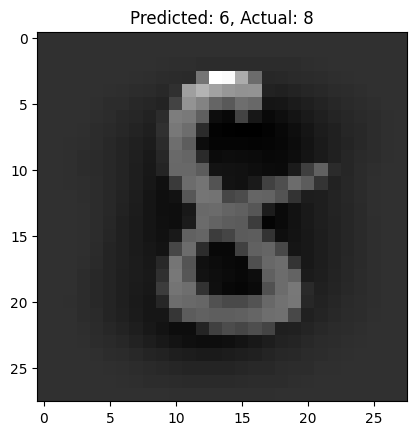

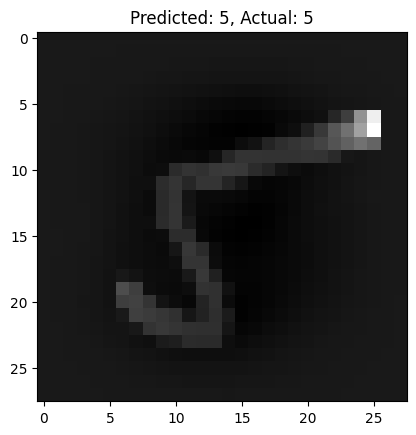

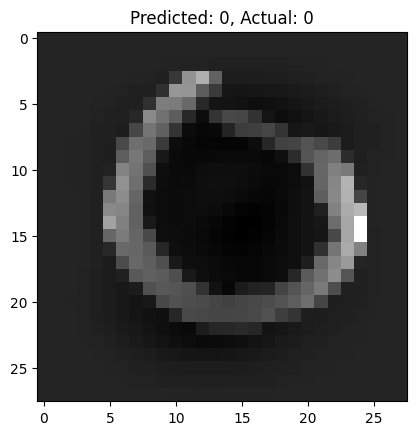

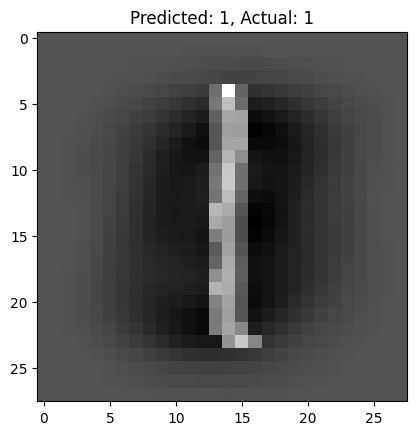

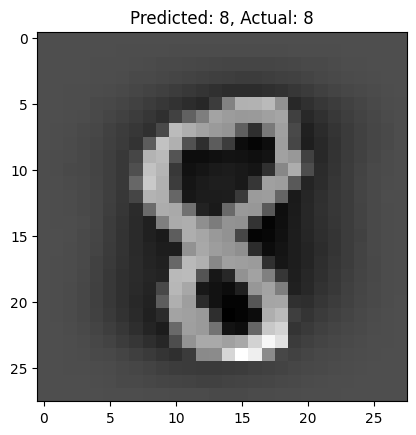

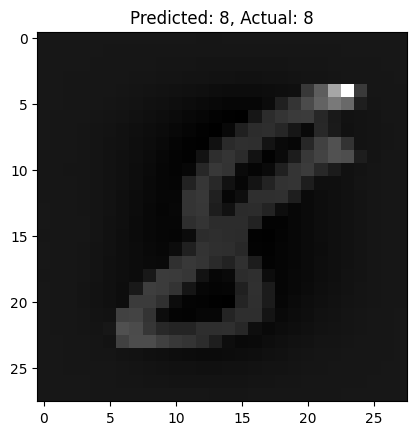

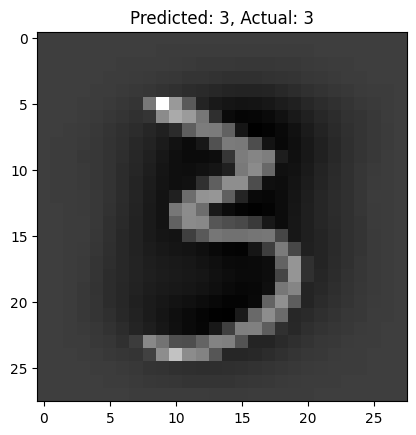

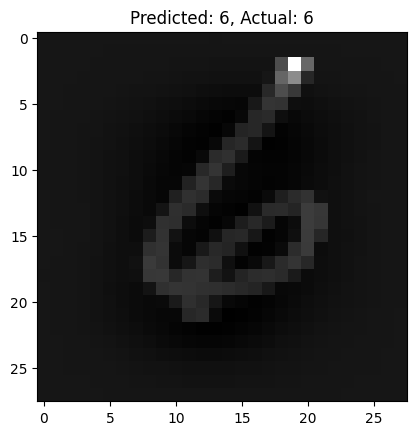

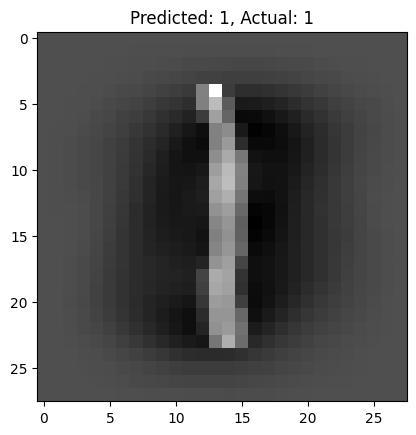

In [509]:
import matplotlib.pyplot as plt
import random 
sample_indices = random.sample(range(X_test.shape[0]), 10)
print(sample_indices)
for i in range(10):
    sample_index = sample_indices[i]
    sample_image = X_test[sample_index][1:].reshape(28, 28)
    sample_label = y_test.iloc[sample_index]
    sample_prediction = y_pred[sample_index]
    plt.imshow(sample_image, cmap='gray')
    plt.title(f'Predicted: {sample_prediction}, Actual: {sample_label}')
    plt.show()


## 总结思考
通过这次自己编写ovo多分类和Softmax多分类实现代码，我对两者的原理有了进一步的了解。同时也认识了一些机器学习领域常用的经典数据集，例如iris和mnist。另外，我对python的使用和numpy的使用也有了进一步的了解，对于numpy中的一些函数的使用也更加熟练了。对于softmax和ovo，在一些机器学习的经典包和深度学习框架中都有涉及，但不直接使用它们，而是尝试自己从原理角度编写，有利于我们更好的理解它们的原理，也有利于我们更好的理解机器学习的一些基本概念。